In [63]:
import json
import os
from collections import defaultdict
import traceback
from difflib import SequenceMatcher
import argparse
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import fitz
from fitz import Rect
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom import minidom
# import editdistance
import numpy as np
import pandas as pd
import cv2
# from tqdm import tqdm

In [2]:
def table_to_text(table_dict):
    return ' '.join([cell['text_content'].strip() for cell in  table_dict['cells']])


In [3]:
def align(page_string="", xml_string="", page_character_rewards=None, xml_character_rewards=None, match_reward=2,
          space_match_reward=3, lowercase_match_reward=2, mismatch_penalty=-5,
          page_new_gap_penalty=-2, xml_new_gap_penalty=-5, page_continue_gap_penalty=-0.01, xml_continue_gap_penalty=-0.1,
          page_boundary_gap_reward=0.01, gap_not_after_space_penalty=-1,
          score_only=False, gap_character='_'):
    '''
    Dynamic programming sequence alignment between two text strings; the first text string
    is considered to come from the PDF document; the second text string is considered to
    come from the XML document.
    Traceback convention: -1 = up, 1 = left, 0 = diag up-left
    '''
    
    scores = np.zeros((len(page_string) + 1, len(xml_string) + 1))
    pointers = np.zeros((len(page_string) + 1, len(xml_string) + 1))
    
    # Initialize first column
    for row_idx in range(1, len(page_string) + 1):
        scores[row_idx, 0] = scores[row_idx - 1, 0] + page_boundary_gap_reward
        pointers[row_idx, 0] = -1
        
    # Initialize first row
    for col_idx in range(1, len(xml_string) + 1):
        #scores[0, col_idx] = scores[0, col_idx - 1] + 0
        pointers[0, col_idx] = 1
        
    for row_idx in range(1, len(page_string) + 1):
        for col_idx in range(1, len(xml_string) + 1):
            # Score if matching the characters
            if page_string[row_idx - 1].lower() == xml_string[col_idx - 1].lower():
                if page_string[row_idx - 1] == ' ':
                    reward = space_match_reward
                elif page_string[row_idx - 1] == xml_string[col_idx - 1]:
                    reward = match_reward
                else:
                    reward = lowercase_match_reward
                if not page_character_rewards is None:
                    reward *= page_character_rewards[row_idx-1]
                if not xml_character_rewards is None:
                    reward *= xml_character_rewards[col_idx-1]
                diag_score = scores[row_idx - 1, col_idx - 1] + reward
            else:
                diag_score = scores[row_idx - 1, col_idx - 1] + mismatch_penalty
            
            if pointers[row_idx, col_idx - 1] == 1:
                same_row_score = scores[row_idx, col_idx - 1] + page_continue_gap_penalty
            else:
                same_row_score = scores[row_idx, col_idx - 1] + page_new_gap_penalty
                if not xml_string[col_idx - 1] == ' ':
                    same_row_score += gap_not_after_space_penalty
            
            if col_idx == len(xml_string):
                same_col_score = scores[row_idx - 1, col_idx] + page_boundary_gap_reward
            elif pointers[row_idx - 1, col_idx] == -1:
                same_col_score = scores[row_idx - 1, col_idx] + xml_continue_gap_penalty
            else:
                same_col_score = scores[row_idx - 1, col_idx] + xml_new_gap_penalty
                if not page_string[row_idx - 1] == ' ':
                    same_col_score += gap_not_after_space_penalty
               
            max_score = max(diag_score, same_col_score, same_row_score)
            scores[row_idx, col_idx] = max_score
            if diag_score == max_score:
                pointers[row_idx, col_idx] = 0
            elif same_col_score == max_score:
                pointers[row_idx, col_idx] = -1
            else:
                pointers[row_idx, col_idx] = 1
    
    score = scores[len(page_string), len(xml_string)]
    
    if score_only:
        return score
    
    cur_row = len(page_string)
    cur_col = len(xml_string)
    aligned_page_string = ""
    aligned_xml_string = ""
    while not (cur_row == 0 and cur_col == 0):
        if pointers[cur_row, cur_col] == -1:
            cur_row -= 1
            aligned_xml_string += gap_character
            aligned_page_string += page_string[cur_row]
        elif pointers[cur_row, cur_col] == 1:
            cur_col -= 1
            aligned_page_string += gap_character
            aligned_xml_string += xml_string[cur_col]
        else:
            cur_row -= 1
            cur_col -= 1
            aligned_xml_string += xml_string[cur_col]
            aligned_page_string += page_string[cur_row]
            
    aligned_page_string = aligned_page_string[::-1]
    aligned_xml_string = aligned_xml_string[::-1]
    
    alignment = [aligned_page_string, aligned_xml_string]
    
    return alignment, score

In [4]:
def locate_table(page_words, table):
    #sorted_words = sorted(words, key=functools.cmp_to_key(compare_meta))
    sorted_words = page_words
    page_text = " ".join([word[4] for word in sorted_words])

    page_text_source = []
    for num, word in enumerate(sorted_words):
        for c in word[4]:
            page_text_source.append(num)
        page_text_source.append(None)
    page_text_source = page_text_source[:-1]
        
    table_text = table_to_text(table)
    table_text_source = []
    for num, cell in enumerate(table['cells']):
        for c in cell['text_content'].strip():
            table_text_source.append(num)
        table_text_source.append(None)
    table_text_source = table_text_source[:-1]

    X = page_text.replace("~", "^")
    Y = table_text.replace("~", "^")

    match_reward = 3
    mismatch_penalty = -2
    #new_gap_penalty = -10
    continue_gap_penalty = -0.05
    page_boundary_gap_reward = 0.2

    alignment, score = align(X, Y, match_reward=match_reward, mismatch_penalty=mismatch_penalty,
                             page_boundary_gap_reward=page_boundary_gap_reward, score_only=False,
          gap_character='~')
    # print(alignment)
    table_words = set()
    column_words = dict()
    row_words = dict()
    cell_words = dict()
    page_count = 0
    table_count = 0
    
    for char1, char2 in zip(alignment[0], alignment[1]):
        if not char1 == "~":
            if char1 == char2:
                table_words.add(page_text_source[page_count])
                cell_num = table_text_source[table_count]
                if not cell_num is None:
                    if cell_num in cell_words:
                        cell_words[cell_num].add(page_text_source[page_count])
                    else:
                        cell_words[cell_num] = set([page_text_source[page_count]])
            page_count += 1
        if not char2 == "~":
            table_count += 1
            
    inliers = []
    for word_num in table_words:
        if word_num:
            inliers.append(sorted_words[word_num])
    
    if len(inliers) == 0:
        return None, None
        
    cell_bboxes = {}
    for cell_num, cell in enumerate(table['cells']):
        cell_bbox = None
        if cell_num in cell_words:
            for word_num in cell_words[cell_num]:
                if not word_num is None:
                    word_bbox = sorted_words[word_num][0:4]
                    if not cell_bbox:
                        cell_bbox = [entry for entry in word_bbox]
                    else:
                        cell_bbox[0] = min(cell_bbox[0], word_bbox[0])
                        cell_bbox[1] = min(cell_bbox[1], word_bbox[1])
                        cell_bbox[2] = max(cell_bbox[2], word_bbox[2])
                        cell_bbox[3] = max(cell_bbox[3], word_bbox[3])
        cell_bboxes[cell_num] = cell_bbox
    
    return cell_bboxes, inliers

In [5]:
def string_similarity(string1, string2):
    return SequenceMatcher(None, string1, string2).ratio()

In [6]:
def create_document_page_image(doc, page_num, zoom=None, output_image_max_dim=1000):
    page = doc[page_num]
    
    if zoom is None:
        zoom = output_image_max_dim / max(page.rect)
        
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix = mat, alpha = False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    return img

In [7]:
def create_table_dict(annotation_data):
    table_dict = {}
    table_dict['reject'] = []
    table_dict['fix'] = []
    
    cells = []
    for cell in annotation_data['cells']:
        new_cell = {}
        new_cell['text_content'] = ' '.join(cell['content']).strip()
        new_cell['pdf_text_tight_bbox'] = []
        new_cell['column_nums'] = list(range(cell['start_col'], cell['end_col']+1))
        new_cell['row_nums'] = list(range(cell['start_row'], cell['end_row']+1))
        new_cell['is_column_header'] = False
        cells.append(new_cell)
        
    # Make sure no grid locations are duplicated
    # Could be bad data or bad parsing algorithm
    grid_cell_locations = []
    for cell in cells:
        for row_num in cell['row_nums']:
            for column_num in cell['column_nums']:
                grid_cell_locations.append((row_num, column_num))
    if not len(grid_cell_locations) == len(set(grid_cell_locations)):
        table_dict['reject'].append("HTML overlapping grid cells")
        
    num_rows = max([max(cell['row_nums']) for cell in cells]) + 1
    num_columns = max([max(cell['column_nums']) for cell in cells]) + 1
        
    table_dict['cells'] = cells
    table_dict['rows'] = {row_num: {'is_column_header': False} for row_num in range(num_rows)}
    table_dict['columns'] = {column_num: {} for column_num in range(num_columns)}
    
    return table_dict

In [8]:
def complete_table_grid(table_dict):
    rects_by_row = defaultdict(lambda: [None, None, None, None])
    rects_by_column = defaultdict(lambda: [None, None, None, None])
    table_rect = Rect()

    # Determine bounding box for rows and columns
    for cell in table_dict['cells']:
        if not 'pdf_text_tight_bbox' in cell or len(cell['pdf_text_tight_bbox']) == 0:
            continue

        bbox = cell['pdf_text_tight_bbox'] 

        table_rect.include_rect(list(bbox))
        
        min_row = min(cell['row_nums'])
        if rects_by_row[min_row][1] is None:
            rects_by_row[min_row][1] = bbox[1]
        else:
            rects_by_row[min_row][1] = min(rects_by_row[min_row][1], bbox[1])
            
        max_row = max(cell['row_nums'])
        if rects_by_row[max_row][3] is None:
            rects_by_row[max_row][3] = bbox[3]
        else:
            rects_by_row[max_row][3] = max(rects_by_row[max_row][3], bbox[3])
            
        min_column = min(cell['column_nums'])
        if rects_by_column[min_column][0] is None:
            rects_by_column[min_column][0] = bbox[0]
        else:
            rects_by_column[min_column][0] = min(rects_by_column[min_column][0], bbox[0])
            
        max_column = max(cell['column_nums'])
        if rects_by_column[max_column][2] is None:
            rects_by_column[max_column][2] = bbox[2]
        else:
            rects_by_column[max_column][2] = max(rects_by_column[max_column][2], bbox[2])

    table_bbox = list(table_rect)
    table_dict['pdf_table_bbox'] = table_bbox

    for row_num, row_rect in rects_by_row.items():
        row_rect[0] = table_bbox[0]
        row_rect[2] = table_bbox[2]

    for col_num, col_rect in rects_by_column.items():
        col_rect[1] = table_bbox[1]
        col_rect[3] = table_bbox[3]
        
    for k, row in table_dict['rows'].items():
        v = rects_by_row[k]
        table_dict['rows'][k]['pdf_row_bbox'] = list(v)
    for k, column in table_dict['columns'].items():
        v = rects_by_column[k]
        table_dict['columns'][k]['pdf_column_bbox'] = list(v)
        
    for k, row in table_dict['rows'].items():    
        for elem in row['pdf_row_bbox']:
            if elem is None:
                table_dict['reject'].append("undetermined row boundary")
    for k, column in table_dict['columns'].items():
        for elem in column['pdf_column_bbox']:
            if elem is None:
                table_dict['reject'].append("undetermined column boundary")
                
    # Adjust bounding boxes if minor overlap
    fixed_overlap = False
    num_rows = len(table_dict['rows'])
    for row_num in range(num_rows-1):
        row1_bbox = table_dict['rows'][row_num]['pdf_row_bbox']
        row2_bbox = table_dict['rows'][row_num+1]['pdf_row_bbox']
        overlap1 = overlap(row1_bbox, row2_bbox)
        overlap2 = overlap(row2_bbox, row1_bbox)
        
        if overlap1 > 0 and overlap2 > 0:
            if overlap1 < 0.18 and overlap2 < 0.18:
                fixed_overlap = True
                midpoint = 0.5 * (row1_bbox[3] + row2_bbox[1])
                table_dict['rows'][row_num]['pdf_row_bbox'][3] = midpoint
                table_dict['rows'][row_num+1]['pdf_row_bbox'][1] = midpoint
                fixed_overlap = True
            else:
                table_dict['reject'].append("rows intersect")
        
    # Intersect each row and column to determine grid cell bounding boxes
    #page_words = page.get_text_words()
    for cell in table_dict['cells']:
        rows_rect = Rect()
        cols_rect = Rect()

        for row_num in cell['row_nums']:
            rows_rect.include_rect(table_dict['rows'][row_num]['pdf_row_bbox'])

        for col_num in cell['column_nums']:
            cols_rect.include_rect(table_dict['columns'][col_num]['pdf_column_bbox'])

        pdf_bbox = rows_rect.intersect(cols_rect)
        cell['pdf_bbox'] = list(pdf_bbox)

In [9]:
def identify_projected_row_headers(table_dict):
    num_cols = len(table_dict['columns'])
    cells_with_text_count_by_row = defaultdict(int)
    all_cells_in_row_only_in_one_row_by_row = defaultdict(lambda: True)
    has_first_column_cell_with_text_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        if len(cell['text_content']) > 0:
            for row_num in cell['row_nums']:
                cells_with_text_count_by_row[row_num] += 1

            if 0 in cell['column_nums']:
                has_first_column_cell_with_text_by_row[row_num] = True

        one_row_only = len(cell['row_nums']) == 1
        for row_num in cell['row_nums']:
            all_cells_in_row_only_in_one_row_by_row[row_num] = all_cells_in_row_only_in_one_row_by_row[row_num] and one_row_only

    projected_row_header_rows = set()
    for row_num, row in table_dict['rows'].items():
        if (not row['is_column_header'] and cells_with_text_count_by_row[row_num] == 1
                and all_cells_in_row_only_in_one_row_by_row[row_num]
                and has_first_column_cell_with_text_by_row[row_num]):
            projected_row_header_rows.add(row_num)
            
    return projected_row_header_rows

In [10]:
def annotate_projected_row_headers(table_dict):    
    num_cols = len(table_dict['columns'])
    projected_row_header_rows = identify_projected_row_headers(table_dict)

    cells_to_remove = []
    for cell in table_dict['cells']:
        if len(set(cell['row_nums']).intersection(projected_row_header_rows)) > 0:
            if len(cell['text_content']) > 0:
                cell['column_nums'] = list(range(num_cols))
                cell['is_projected_row_header'] = True
            else:
                cells_to_remove.append(cell) # Consolidate blank cells after the first cell into the projected row header
        else:
            cell['is_projected_row_header'] = False

    for cell in cells_to_remove:
        table_dict['fix'].append('merged projected row header')
        table_dict['cells'].remove(cell)
        
    for row_num, row in table_dict['rows'].items():
        if row_num in projected_row_header_rows:
            row['is_projected_row_header'] = True
        else:
            row['is_projected_row_header'] = False
            
    # Delete projected row headers in last rows
    num_rows = len(table_dict['rows'])
    row_nums_to_delete = []
    for row_num in range(num_rows-1, -1, -1):
        if table_dict['rows'][row_num]['is_projected_row_header']:
            row_nums_to_delete.append(row_num)
        else:
            break
            
    if len(row_nums_to_delete) > 0:
        for row_num in row_nums_to_delete:
            del table_dict['rows'][row_num]
            table_dict['fix'].append('removed projected row header at bottom of table')
            for cell in table_dict['cells'][:]:
                if row_num in cell['row_nums']:
                    table_dict['cells'].remove(cell)


In [11]:
def remove_empty_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['text_content'].strip()) > 0
        for row_num in cell['row_nums']:
            has_content_by_row[row_num] = has_content_by_row[row_num] or has_content
    row_num_corrections = np.cumsum([int(not has_content_by_row[row_num]) for row_num in range(num_rows)]).tolist()
    
    # Delete cells in empty rows and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_row_nums = []
        for row_num in cell['row_nums']:
            if has_content_by_row[row_num]:
                new_row_nums.append(row_num - row_num_corrections[row_num])
        cell['row_nums'] = new_row_nums
        if len(new_row_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty row')
        table_dict['cells'].remove(cell)
    
    rows = {}
    for row_num, has_content in has_content_by_row.items():
        if has_content:
            new_row_num = row_num - row_num_corrections[row_num]
            rows[new_row_num] = table_dict['rows'][row_num]
    table_dict['rows'] = rows

In [12]:
def remove_empty_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_column = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['text_content'].strip()) > 0
        for column_num in cell['column_nums']:
            has_content_by_column[column_num] = has_content_by_column[column_num] or has_content
    column_num_corrections = np.cumsum([int(not has_content_by_column[column_num]) for column_num in range(num_columns)]).tolist()
    
    # Delete cells in empty columns and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_column_nums = []
        for column_num in cell['column_nums']:
            if has_content_by_column[column_num]:
                new_column_nums.append(column_num - column_num_corrections[column_num])
        cell['column_nums'] = new_column_nums
        if len(new_column_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty column')
        table_dict['cells'].remove(cell)
    
    columns = {}
    for column_num, has_content in has_content_by_column.items():
        if has_content:
            new_column_num = column_num - column_num_corrections[column_num]
            columns[new_column_num] = table_dict['columns'][column_num]
    table_dict['columns'] = columns

In [13]:
def merge_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_columns, num_columns))
    for cell in table_dict['cells']:
        for column_num1 in cell['column_nums']:
            for column_num2 in cell['column_nums']:
                if column_num1 >= column_num2:
                    continue
                co_occurrence_matrix[column_num1, column_num2] += len(cell['row_nums'])
                
    new_column_num = 0
    current_column_group = 0
    keep_column = [True]
    column_grouping = [current_column_group]
    for column_num in range(num_columns-1):
        if not co_occurrence_matrix[column_num, column_num+1] == num_rows:
            keep_column.append(True)
            new_column_num += 1
        else:
            table_dict['fix'].append('merged columns spanned together in every row')
            keep_column.append(False)
        column_grouping.append(new_column_num)

    for cell in table_dict['cells']:
        cell['column_nums'] = [column_grouping[column_num] for column_num in cell['column_nums'] if keep_column[column_num]]
        
    table_dict['columns'] = {column_grouping[column_num]: table_dict['columns'][column_num] for column_num in range(num_columns) if keep_column[column_num]}


In [14]:
def merge_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_rows, num_rows))
    for cell in table_dict['cells']:
        for row_num1 in cell['row_nums']:
            for row_num2 in cell['row_nums']:
                if row_num1 >= row_num2:
                    continue
                co_occurrence_matrix[row_num1, row_num2] += len(cell['column_nums'])
                
    new_row_num = 0
    current_row_group = 0
    keep_row = [True]
    row_grouping = [current_row_group]
    for row_num in range(num_rows-1):
        if not co_occurrence_matrix[row_num, row_num+1] == num_columns:
            keep_row.append(True)
            new_row_num += 1
        else:
            table_dict['fix'].append('merged rows spanned together in every column')
            keep_row.append(False)
        row_grouping.append(new_row_num)

    for cell in table_dict['cells']:
        cell['row_nums'] = [row_grouping[row_num] for row_num in cell['row_nums'] if keep_row[row_num]]
        
    table_dict['rows'] = {row_grouping[row_num]: table_dict['rows'][row_num] for row_num in range(num_rows) if keep_row[row_num]} 
    

In [15]:
def correct_header(table_dict, assume_header_if_more_than_two_columns=True):
    num_columns = len(table_dict['columns'])
    num_rows = len(table_dict['rows'])
    
    if num_columns < 2 or num_rows < 1:
        table_dict['reject'].append("small table")
        #raise SmallTableException("Table does not have at least one row and two columns") 
        
    #---DETERMINE FULL EXTENT OF COLUMN HEADER
    # - Each of the below steps determines different rows that must be in the column header.
    # - The final column header includes all rows that are originally annotated as being in the column
    #   header plus any additional rows determined to be in the column header by the following steps.
    
    table_has_column_header = False
    
    # First determine if there is definitely a column header. Four cases:
    
    # 1. We specify that we want to assume there is one for all tables with more than two columns:
    if assume_header_if_more_than_two_columns and num_columns > 2:
        table_has_column_header = True
    
    # 2. An annotator says there is
    if not table_has_column_header:
        header_rows = [row_num for row_num, row in table_dict['rows'].items() if row['is_column_header']]
        if 0 in header_rows:
            table_has_column_header = True
        
    # 3. The cell occupying the first row and column is blank
    if not table_has_column_header:
        for cell in table_dict['cells']:
            if 0 in cell['column_nums'] and 0 in cell['row_nums'] and len(cell['text_content'].strip()) == 0:
                table_has_column_header = True
                break
    
    # 4. There is a horizontal spanning cell in the first row
    if not table_has_column_header:
        for cell in table_dict['cells']:
            if 0 in cell['row_nums'] and len(cell['column_nums']) > 1:
                table_has_column_header = True
                break

    # Then determine if the column header needs to be extended past its current annotated extent.
    #  1. A header that already is annotated in at least one row continues at least until each column
    #     has a cell occupying only that column
    #  2. A header with a column with a blank cell must continue at least as long as the blank cells continue
    #     (unless rule #1 is satisfied and a possible projected row header is reached?)
    if table_has_column_header:
        # Do not use this rule; while perhaps not ideal, columns can have the same header
        #print("Flattening header")
        #num_rows = len(table_dict['rows'])
        #num_columns = len(table_dict['columns'])
        #cell_grid = np.zeros((num_rows, num_columns)).astype('str').tolist()
        #for cell in table_dict['cells']:
        #    for row_num in cell['row_nums']:
        #        for column_num in cell['column_nums']:
        #            cell_grid[row_num][column_num] = cell['text_content']
        #flattened_header = ['' for column_num in range(num_columns)]
        #for row_num in range(num_rows):
        #    unique_headers = True
        #    for column_num in range(num_columns):
        #        flattened_header[column_num] += ' ' + cell_grid[row_num][column_num]
        #        flattened_header[column_num] = flattened_header[column_num].strip()
        #    print(flattened_header)
        #    for column_num1 in range(num_columns-1):
        #        for column_num2 in range(column_num1+1, num_columns):
        #            if flattened_header[column_num1] == flattened_header[column_num2] and len(flattened_header[column_num1]) > 0:
        #                unique_headers = False
        #    if unique_headers:
        #        break
        #unique_header_row = row_num
        #print(unique_header_row)
        
        first_column_filled_by_row = defaultdict(bool)
        for cell in table_dict['cells']:
            if 0 in cell['column_nums']:
                if len(cell['text_content']) > 0:
                    for row_num in cell['row_nums']:
                        first_column_filled_by_row[row_num] = True        
        
        first_column_filled_by_row = defaultdict(bool)
        for cell in table_dict['cells']:
            if 0 in cell['column_nums']:
                if len(cell['text_content']) > 0:
                    for row_num in cell['row_nums']:
                        first_column_filled_by_row[row_num] = True
        
        first_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['column_nums']) == 1:
                first_single_node_row_by_column[cell['column_nums'][0]] = min(first_single_node_row_by_column[cell['column_nums'][0]],
                                                                               max(cell['row_nums']))
                
        first_filled_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['column_nums']) == 1 and len(cell['text_content'].strip()) > 0:
                first_filled_single_node_row_by_column[cell['column_nums'][0]] = min(first_filled_single_node_row_by_column[cell['column_nums'][0]],
                                                                               max(cell['row_nums']))
                
        first_filled_cell_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['text_content']) > 0:
                min_row_num = min(cell['row_nums'])
                for column_num in cell['column_nums']:
                    first_filled_cell_by_column[column_num] = min(first_filled_cell_by_column[column_num],
                                                                  min_row_num)
                    
        projected_row_header_rows = identify_projected_row_headers(table_dict)
        if 0 in projected_row_header_rows:
            table_dict['reject'].append("bad projected row header")
            #raise BadProjectedRowHeaderException('Starting with PRH')
        #for row_num in range(num_rows):
        #    if row_num in projected_row_header_rows:
        #        projected_row_header_rows.remove(row_num)
        #    else:
        #        break
        
        # Header must continue until at least this row
        minimum_grid_cell_single_node_row = max(first_single_node_row_by_column.values())
        
        # Header can stop prior to the first of these rows that occurs after the above row
        minimum_first_body_row = min(num_rows-1, max(first_filled_cell_by_column.values()))
        
        # Determine the max row for which a column N has been single and filled but column N+1 has not
        minimum_all_following_filled = -1
        for row_num in range(num_rows):
            for column_num1 in range(num_columns-1):
                for column_num2 in range(column_num1+1, num_columns):
                    if (first_filled_single_node_row_by_column[column_num2] > row_num
                        and first_filled_single_node_row_by_column[column_num1] < first_filled_single_node_row_by_column[column_num2]):
                        minimum_all_following_filled = row_num + 1

        #minimum_projected_row_header_row = min([num_rows-1] + [elem for elem in projected_row_header_rows if elem > minimum_grid_cell_single_node_row])
        if len(projected_row_header_rows) > 0:
            minimum_projected_row_header_row = min(projected_row_header_rows)
        else:
            minimum_projected_row_header_row = num_rows

        #first_possible_last_header_row = min(minimum_first_body_row, minimum_projected_row_header_row) - 1
        first_possible_last_header_row = minimum_first_body_row - 1
                    
        last_header_row = max(minimum_all_following_filled,
                              minimum_grid_cell_single_node_row,
                              first_possible_last_header_row)
        
        x = last_header_row
        while(last_header_row < num_rows and not first_column_filled_by_row[last_header_row+1]):
            last_header_row += 1            
        
        #incomplete_header = False # temp for debugging
        if minimum_projected_row_header_row <= last_header_row:
            last_header_row = minimum_projected_row_header_row - 1
            #incomplete_header = True
        
        for cell in table_dict['cells']:
            if max(cell['row_nums']) <= last_header_row:
                cell['is_column_header'] = True
        
        for row_num, row in table_dict['rows'].items():
            if row_num <= last_header_row:
                row['is_column_header'] = True
                
        #if not x == last_header_row:
        #    raise DebugException("Header extended")
                
        #if minimum_all_following_filled == last_header_row:
        #    raise DebugException
        
        #if incomplete_header:
        #    raise IncompleteHeaderException("Set last header row to be just before minimum projected row header row".format(last_header_row, minimum_projected_row_header_row))
    
    if not table_has_column_header and num_columns == 2:
        table_dict['reject'].append("ambiguous header")


In [16]:
def canonicalize(table_dict):
    # Preprocessing step: Split every blank spanning cell in the column header into blank grid cells.
    cells_to_delete = []
    try:
        for cell in table_dict['cells']:
            if (cell['is_column_header'] and len(cell['text_content'].strip()) == 0
                    and (len(cell['column_nums']) > 1 or len(cell['row_nums']) > 1)):
                cells_to_delete.append(cell)
                # Split this blank spanning cell into blank grid cells
                for column_num in cell['column_nums']:
                    for row_num in cell['row_nums']:
                        #row_bbox = table_dict['rows'][row_num]['pdf_row_bbox']
                        #column_bbox = table_dict['columns'][column_num]['pdf_column_bbox']
                        #bbox = list(Rect(row_bbox).intersect(list(column_bbox)))
                        new_cell = {'text_content': '',
                                    'column_nums': [column_num],
                                    'row_nums': [row_num],
                                    'is_column_header': cell['is_column_header'],
                                    'pdf_text_tight_bbox': [],
                                    'is_projected_row_header': False}
                        table_dict['cells'].append(new_cell)
    except:
        print(traceback.format_exc())
    for cell in cells_to_delete:
        table_dict['cells'].remove(cell)
        
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go bottom up, try to extend non-blank cells up to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = min(cell['row_nums']) - 1
        for row_num in range(next_row_num, -1, -1):
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
            
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
                
    num_rows = len(table_dict['rows'])
    # Go top down, try to extend non-blank cells down to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = max(cell['row_nums']) + 1
        for row_num in range(next_row_num, num_rows):
            if not table_dict['rows'][row_num]['is_column_header']:
                break
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
    
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go top down, merge any neighboring cells occupying the same columns, whether they are blank or not
    header_groups_by_row_column = defaultdict(list)
    header_groups = []
    do_full_break = False
    for row_num in table_dict['rows']:
        for column_num in table_dict['columns']:
            cell = cell_grid_index[(row_num, column_num)]
            if not cell['is_column_header']:
                do_full_break = True
                break
            if len(header_groups_by_row_column[(row_num, column_num)]) > 0:
                continue
            if not row_num == min(cell['row_nums']) and column_num == min(cell['column_nums']):
                continue
            # Start new header group
            header_group = [cell]
            next_row_num = max(cell['row_nums']) + 1
            while next_row_num < num_rows:
                cell2 = cell_grid_index[(next_row_num, column_num)]
                if cell2['is_column_header'] and set(cell['column_nums']) == set(cell2['column_nums']):
                    header_group.append(cell2)
                    for row_num2 in cell2['row_nums']:
                        for column_num2 in cell2['column_nums']:
                            header_groups_by_row_column[(row_num2, column_num2)] = header_group
                else:
                    break
                next_row_num = max(cell2['row_nums']) + 1
            for row_num2 in cell['row_nums']:
                for column_num2 in cell['column_nums']:
                    header_groups_by_row_column[(row_num2, column_num2)] = header_group
            if len(header_group) > 1:
                header_groups.append(header_group)
        if do_full_break:
            break
    for group in header_groups:
        merge_group(table_dict, group)
        
    # Merge spanning cells in the row header
    merge_spanning_cells_in_first_column(table_dict)

In [17]:
def merge_spanning_cells_in_first_column(table_dict):
    first_column_cells = [cell for cell in table_dict['cells'] if 0 in cell['column_nums']]
    first_column_cells = sorted(first_column_cells, key=lambda item: max(item['row_nums']))
    
    first_column_merge_exclude = set()
    
    # Look for blank cells at bottom of first column
    text_by_row_num = {}
    for cell in table_dict['cells']:
        if 0 in cell['column_nums']:
            for row_num in cell['row_nums']:
                if not cell['is_column_header']:
                    text_by_row_num[row_num] = cell['text_content'].strip()
                else:
                    text_by_row_num[row_num] = "_"
    bottom_blank_rows = set()
    blank_rows = set()
    still_bottom = True
    add_bottom_rows = True
    for row_num in sorted(table_dict['rows'].keys(), reverse=True):
        if len(text_by_row_num[row_num]) > 0:
            still_bottom = False
        elif still_bottom:
            bottom_blank_rows.add(row_num)
        else:
            add_bottom_rows = False
            break
    if add_bottom_rows:
        first_column_merge_exclude = first_column_merge_exclude.union(bottom_blank_rows)
    
    
    # Look for tables with multiple headers
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    cell_grid = np.zeros((num_rows, num_columns)).astype('str').tolist()
    for cell in table_dict['cells']:
        for row_num in cell['row_nums']:
            for column_num in cell['column_nums']:
                cell_grid[row_num][column_num] = cell['text_content']
    for row_num1 in range(num_rows-1):
        row1 = table_dict['rows'][row_num1]
        if not row1['is_column_header']:
            continue
        for row_num2 in range(row_num1+1, num_rows):
            row2 = table_dict['rows'][row_num2]
            if row2['is_column_header']:
                continue
            if cell_grid[row_num1] == cell_grid[row_num2]:
                first_column_merge_exclude.add(row_num2)
    for cell1 in table_dict['cells']:
        for cell2 in table_dict['cells']:
            if cell1['is_column_header'] and not cell2['is_column_header']:
                if cell1['text_content'] == cell2['text_content'] and len(cell1['text_content'].strip()) > 0:
                    for row_num in cell2['row_nums']:
                        first_column_merge_exclude.add(row_num)
    
    current_filled_cell = None
    groups = defaultdict(list)
    group_num = -1
    for cell in first_column_cells:
        if len(set(cell['row_nums']).intersection(first_column_merge_exclude)) > 0:
            group_num += 1
        elif len(cell['text_content']) > 0:
            group_num += 1
        if group_num >= 0:
            groups[group_num].append(cell)
        
    for group_num, group in groups.items():
        if len(group) > 1 and not group[0]['is_projected_row_header'] and not group[0]['is_column_header']:
            merge_group(table_dict, group)

In [18]:
def extract_pdf_text(table_dict, page_words, threshold=0.5):
    adjusted_text_tight_bbox = False
    for cell in table_dict['cells']:
        pdf_text_tight_bbox = cell['pdf_text_tight_bbox']
        pdf_bbox = cell['pdf_bbox']
        
        cell_page_words = [w for w in page_words if Rect(w[:4]).intersect(list(pdf_bbox)).get_area() / Rect(w[:4]).get_area() > threshold]
        cell_words = [w[4] for w in cell_page_words]
        cell_text = ''.join(cell_words)
        
        # Remove trailing dots from cell_page_words
        # Some of the original annotations include dots in the pdf_text_tight_bbox when they shouldn't
        # This code ensures that those are fixed, plus that dots are not added by extracting text from the
        # entire grid cell
        if len(cell_text) > 2 and cell_text[-1] == '.' and cell_text[-2] == '.':
            for page_word in cell_page_words[::-1]:
                if is_all_dots(page_word[4]):
                    table_dict['fix'].append('removed dots from text cell')
                    cell_page_words.remove(page_word)
                else:
                    break
        
        cell_words_rect = Rect()
        for w in cell_page_words:
            cell_words_rect.include_rect(w[:4])
        cell_words = [w[4] for w in cell_page_words]
        cell_text = ' '.join(cell_words)
        cell_text = cell_text.replace(' .', '.').replace(' ,', ',')
        if cell_text.endswith('..'):
            table_dict['reject'].append("dots retained")
            #raise DotsRetainedException("Dots retained in text [{}] '{}'".format(cell_words, cell_text))
        cell['pdf_text_content'] = cell_text
        if cell_words_rect.get_area() > 0:
            new_pdf_text_tight_bbox = list(cell_words_rect)
            if not pdf_text_tight_bbox == new_pdf_text_tight_bbox:
                adjusted_text_tight_bbox = True
                cell['pdf_text_tight_bbox'] = new_pdf_text_tight_bbox
                
    return adjusted_text_tight_bbox

In [19]:
def overlap(bbox1, bbox2):
    try:
        return Rect(bbox1).intersect(list(bbox2)).get_area() / Rect(bbox1).get_area()
    except:
        return 1

In [20]:
def get_table(table_dict):
    rects_by_row = defaultdict(lambda: [None, None, None, None])
    rects_by_column = defaultdict(lambda: [None, None, None, None])
    table_rect = Rect()
    for cell in table_dict['cells']:
        if not 'pdf_text_tight_bbox' in cell or len(cell['pdf_text_tight_bbox']) == 0:
            continue

        bbox = cell['pdf_text_tight_bbox'] 

        table_rect.include_rect(list(bbox))
        
        min_row = min(cell['row_nums'])
        if rects_by_row[min_row][1] is None:
            rects_by_row[min_row][1] = bbox[1]
        else:
            rects_by_row[min_row][1] = min(rects_by_row[min_row][1], bbox[1])
            
        max_row = max(cell['row_nums'])
        if rects_by_row[max_row][3] is None:
            rects_by_row[max_row][3] = bbox[3]
        else:
            rects_by_row[max_row][3] = max(rects_by_row[max_row][3], bbox[3])
            
        min_column = min(cell['column_nums'])
        if rects_by_column[min_column][0] is None:
            rects_by_column[min_column][0] = bbox[0]
        else:
            rects_by_column[min_column][0] = min(rects_by_column[min_column][0], bbox[0])
            
        max_column = max(cell['column_nums'])
        if rects_by_column[max_column][2] is None:
            rects_by_column[max_column][2] = bbox[2]
        else:
            rects_by_column[max_column][2] = max(rects_by_column[max_column][2], bbox[2])

    table_bbox = list(table_rect)
    # table_dict['pdf_table_bbox'] = table_bbox
    return table_bbox

In [109]:
def get_row_bbox(num_rows, table_dict, image , bbox_table ):
    h,w,c = image.shape
    row_dict = {key : [] for key in range(num_rows)}
    x1_table, y1_table, x2_table, y2_table = bbox_table
    for cell in table_dict['cells']:
        if len(cell['row_nums']) == 1:
            # single cell
            idx_row = cell['row_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            if len(ori_bbox) == 0:
                continue
            x1 , y1 , x2 , y2 = ori_bbox
            x1_bbox = x1 - x1_table
            y1_bbox = y1 - y1_table
            x2_bbox = x2 - x1_table
            y2_bbox = y2 - y1_table
            bbox_cell_new = [x1_bbox, y1_bbox, x2_bbox, y2_bbox]
            row_dict[idx_row].append(bbox_cell_new)
    row_bbox_final = []
    for row_element in row_dict:
        row_element = np.array(row_dict[row_element])
        if len(row_element) == 0:
            continue    
        y1_min = np.min(row_element[:,1]) 
        y2_max = np.max(row_element[:,3])
        
        x1 = 0
        x2 = w
        row_bbox_final.append([x1, y1_min, x2, y2_max])       
    return row_bbox_final

In [110]:
def get_col_bbox(num_rows, table_dict, image , bbox_table ):
    h,w,c = image.shape
    col_dict = {key : [] for key in range(num_rows)}
    x1_table, y1_table, x2_table, y2_table = bbox_table
    for cell in table_dict['cells']:
        if len(cell['column_nums']) == 1:
            # single cell
            idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            if len(ori_bbox) == 0:
                continue
            x1 , y1 , x2 , y2 = ori_bbox
            x1_bbox = x1 - x1_table
            y1_bbox = y1 - y1_table
            x2_bbox = x2 - x1_table
            y2_bbox = y2 - y1_table
            bbox_cell_new = [x1_bbox, y1_bbox, x2_bbox, y2_bbox]
            col_dict[idx_col].append(bbox_cell_new)
    col_bbox_final = []
    for col_element in col_dict:
        col_element = np.array(col_dict[col_element])
        if len(col_element) == 0:
            continue    
        x1_min = np.min(col_element[:,0]) 
        x2_max = np.max(col_element[:,2])
        
        y1 = 0
        y2 = h
        col_bbox_final.append([x1_min, y1, x2_max, y2])       
    return col_bbox_final

In [89]:
def get_row_binary(row_bbox_final, image):
    h,w,c = np.array(image).shape
    row_image = np.zeros(shape = (h,w))
    row_1d = np.zeros(shape = (h,), dtype = np.uint8)

    for row_bbox in row_bbox_final:
        x1 = int(row_bbox[0])
        y1 = int(row_bbox[1])
        x2 = int(row_bbox[2])
        y2 = int(row_bbox[3])
        row_image[y1:y2, x1:x2] = 1
        row_1d[y1:y2] = 1
    return row_image, row_1d

In [90]:
def get_col_binary(col_bbox_final, image):
    h,w,c = np.array(image).shape
    col_image = np.zeros(shape = (h,w))
    col_1d = np.zeros(shape =(w,),dtype =  np.uint8)

    for col_bbox in col_bbox_final:
        x1 = int(col_bbox[0])
        y1 = int(col_bbox[1])
        x2 = int(col_bbox[2])
        y2 = int(col_bbox[3])
        col_image[y1:y2, x1:x2] = 1
        col_1d[x1:x2] = 1
    return col_image, col_1d

In [84]:
def make_image_row(row, image):
    h,w,c = np.array(image).shape
    img_row = np.zeros((h, w), dtype=np.uint8)  
    mask_img_row = np.where(row ==1 )
    img_row[mask_img_row,:] = 1
    # img_row = cv2.resize(img_row, new_shape)
    img_row  = np.array(img_row)
    return img_row

In [85]:
def make_image_col(col, image):
    h,w,c = np.array(image).shape
    img_col = np.zeros((h, w), dtype=np.uint8)  
    mask_img_col = np.where(col ==1 )
    img_col[:,mask_img_col] = 1
    # img_col = cv2.resize(img_col, new_shape)
    img_col  = np.array(img_col)
    return img_col

In [21]:
structure_filepath = "D:/LV/SciTSR/train/structure/0705.0450v1.6.json"
with open(structure_filepath , 'r') as infile:
    data = json.load(infile)


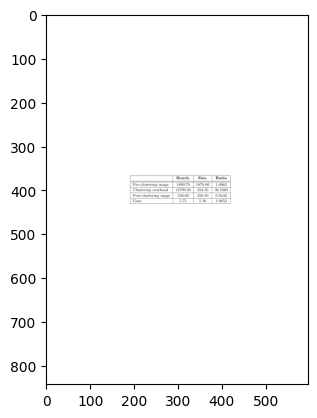

In [22]:
data['cells'] = sorted(sorted(data['cells'], key=lambda x: x['start_col']), key=lambda x: x['start_row'])
table_dict = create_table_dict(data)
img_filepath = structure_filepath.replace("structure", "img").replace(".json", ".png")
pdf_filepath = structure_filepath.replace("structure", "pdf").replace(".json", ".pdf")
doc = fitz.open(pdf_filepath)
page = doc[0]
page_words = page.get_text_words()
image_pdf = page.get_pixmap()
image_pdf.save('pdf_img.png')
img_pdf = Image.open('pdf_img.png')
plt.imshow(img_pdf)
plt.show()

In [23]:
padding = 0
page_rect = page.mediabox
for word in page_words:
    bbox = word[:4]
    bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]
    print(f'{word[4]}    {bbox}')
    page_rect.include_rect(bbox)
cell_bboxes, inliers = locate_table(page_words, table_dict)
for cell, cell_bbox in zip(table_dict['cells'], cell_bboxes.values()):
    if cell_bbox is None:
        cell_bbox = []
    cell['pdf_text_tight_bbox'] = cell_bbox
tables = [table_dict]

Bench.    [296.177001953125, 369.73321533203125, 327.7297668457031, 378.6996154785156]
Sim.    [346.1090087890625, 369.73321533203125, 366.73175048828125, 378.6996154785156]
Ratio    [385.8429870605469, 369.73321533203125, 411.3254699707031, 378.6996154785156]
Pre-clustering    [197.5590057373047, 384.0802307128906, 253.59002685546875, 393.046630859375]
usage    [256.6654968261719, 384.0802307128906, 278.7318115234375, 393.046630859375]
1890.70    [296.85699462890625, 384.0802307128906, 327.0648193359375, 393.046630859375]
1878.80    [341.3219909667969, 384.0802307128906, 371.5298156738281, 393.046630859375]
1.0063    [385.7869873046875, 384.0802307128906, 411.3860778808594, 393.046630859375]
Clustering    [197.5590057373047, 396.4332275390625, 239.100341796875, 405.3996276855469]
overhead    [242.1758270263672, 396.4332275390625, 277.7724609375, 405.3996276855469]
12799.60    [294.5530090332031, 396.4332275390625, 329.36956787109375, 405.3996276855469]
354.50    [343.6260070800781, 39

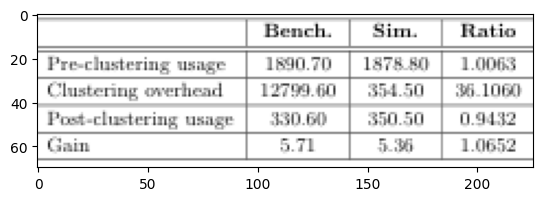

In [24]:
padding = 5
bbox_table = get_table(table_dict)
x1 , y1 , x2 , y2 = bbox_table
bbox_table = [x1-padding, y1-padding, x2+padding, y2+padding]
x1_new , y1_new , x2_new , y2_new = bbox_table  
image_table = img_pdf.crop((x1_new, y1_new, x2_new, y2_new))  
plt.imshow(image_table)
plt.show()


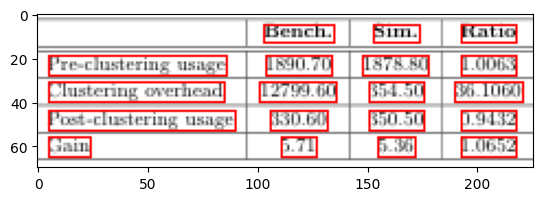

In [25]:
draw = ImageDraw.Draw(image_table)
for cell in table_dict['cells']:
    bbox_cell = cell['pdf_text_tight_bbox']
    if len(bbox_cell) == 0:
        continue
    x1_cell , y1_cell , x2_cell , y2_cell = bbox_cell
    x1_cell_new = x1_cell - x1_new
    y1_cell_new = y1_cell - y1_new
    x2_cell_new = x2_cell - x1_new
    y2_cell_new = y2_cell - y1_new
    bbox_cell_new = [x1_cell_new, y1_cell_new, x2_cell_new, y2_cell_new]
    
    draw.rectangle(bbox_cell_new, outline="red")
plt.imshow(image_table)
plt.show()

In [26]:
complete_table_grid(table_dict)

In [27]:
table_dict

{'reject': [],
 'fix': [],
 'cells': [{'text_content': '',
   'pdf_text_tight_bbox': [],
   'column_nums': [0],
   'row_nums': [0],
   'is_column_header': False,
   'pdf_bbox': [197.5590057373047,
    369.73321533203125,
    282.6053161621094,
    378.6996154785156]},
  {'text_content': 'Bench.',
   'pdf_text_tight_bbox': [296.177001953125,
    369.73321533203125,
    327.7297668457031,
    378.6996154785156],
   'column_nums': [1],
   'row_nums': [0],
   'is_column_header': False,
   'pdf_bbox': [294.5530090332031,
    369.73321533203125,
    329.36956787109375,
    378.6996154785156]},
  {'text_content': 'Sim.',
   'pdf_text_tight_bbox': [346.1090087890625,
    369.73321533203125,
    366.73175048828125,
    378.6996154785156],
   'column_nums': [2],
   'row_nums': [0],
   'is_column_header': False,
   'pdf_bbox': [341.3219909667969,
    369.73321533203125,
    371.5298156738281,
    378.6996154785156]},
  {'text_content': 'Ratio',
   'pdf_text_tight_bbox': [385.8429870605469,
    36

In [28]:
data_frame_filename = {}
file_list =  os.listdir('D:/LV/SciTSR/train/structure/')
for file in file_list:
    file_name = file[:-5]
    data_frame_filename[file] = []

In [29]:
final_data = pd.DataFrame(data_frame_filename.items())
final_data.to_csv("scitsr_filename.csv", index=False)

In [30]:
root_data_path = "D:/LV/SciTSR/train/structure/"   

In [58]:
i

92

In [31]:
i = 67

In [60]:
image_save_folder_path = 'C:/Users/PC/Desktop/git/scitsr_process/data_scitsr/split/table_image/'

In [145]:
data_frame = {}
data_frame_bbox_table = {}

126


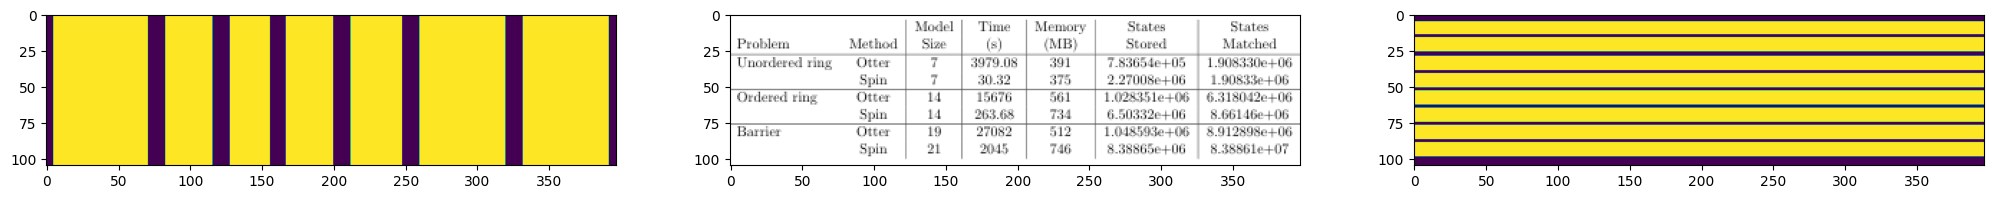

In [149]:
i = i+1
print(i)
test_data = pd.read_csv("scitsr_filename.csv")
test_file  = test_data.iloc[i][0]    
structure_filepath = root_data_path + test_file
with open(structure_filepath , 'r') as infile:
    data = json.load(infile)
data['cells'] = sorted(sorted(data['cells'], key=lambda x: x['start_col']), key=lambda x: x['start_row'])
table_dict = create_table_dict(data)
if table_dict['reject']:
    print("Table rejected")
else:
    img_filepath = structure_filepath.replace("structure", "img").replace(".json", ".png")
    pdf_filepath = structure_filepath.replace("structure", "pdf").replace(".json", ".pdf")
    doc = fitz.open(pdf_filepath)
    page = doc[0]
    page_words = page.get_text_words()
    image_pdf = page.get_pixmap()
    image_pdf = np.frombuffer(image_pdf.samples, dtype=np.uint8).reshape(image_pdf.height, image_pdf.width, image_pdf.n)
    img_pdf = Image.fromarray(image_pdf)
    padding = 0

    page_rect = page.mediabox
    for word in page_words:
        bbox = word[:4]
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]
        page_rect.include_rect(bbox)
    cell_bboxes, inliers = locate_table(page_words, table_dict)
    for cell, cell_bbox in zip(table_dict['cells'], cell_bboxes.values()):
        if cell_bbox is None:
            cell_bbox = []
        cell['pdf_text_tight_bbox'] = cell_bbox
    tables = [table_dict]

    padding = 5
    bbox_table = get_table(table_dict)
    x1 , y1 , x2 , y2 = bbox_table
    bbox_table = [x1-padding, y1-padding, x2+padding, y2+padding]
    x1_new , y1_new , x2_new , y2_new = bbox_table  
    x1_table , y1_table , x2_table , y2_table = bbox_table
    
    image_table = img_pdf.crop((x1_new, y1_new, x2_new, y2_new))  
    
    # save image table 
    image_table_save_name = image_save_folder_path + test_file.replace(".json", ".png")
    image_np = np.array(image_table)    
    cv2.imwrite(image_table_save_name , image_np)

    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    row_bbox = get_row_bbox(num_rows, table_dict, image_pdf , bbox_table)
    col_bbox = get_col_bbox(num_columns, table_dict, image_pdf , bbox_table)
    
    row_image, row_1d = get_row_binary(row_bbox, image_table)
    col_image, col_1d = get_col_binary(col_bbox, image_table)

    file_name_save  = test_file.replace(".json", "_")
    data_binary = [row_1d.tolist(), col_1d.tolist()]
    update = {file_name_save : data_binary}
    data_frame.update(**update)

    image_row_ = make_image_row(row_1d, image_np)
    image_col_ = make_image_col(col_1d, image_np)
    fig, ax = plt.subplots(1,3, figsize=(25, 25))
    ax[0].imshow(image_col_)
    ax[1].imshow(image_np)
    ax[2].imshow(image_row_)
    # draw = ImageDraw.Draw(image_table)
    # for cell in table_dict['cells']:
    #     bbox_cell = cell['pdf_text_tight_bbox']
    #     if len(bbox_cell) == 0:
    #         continue
    #     x1_cell , y1_cell , x2_cell , y2_cell = bbox_cell
    #     x1_cell_new = x1_cell - x1_new
    #     y1_cell_new = y1_cell - y1_new
    #     x2_cell_new = x2_cell - x1_new
    #     y2_cell_new = y2_cell - y1_new
    #     bbox_cell_new = [x1_cell_new, y1_cell_new, x2_cell_new, y2_cell_new]
        
    #     draw.rectangle(bbox_cell_new, outline="red")
    # plt.imshow(image_table)
    # plt.show()

In [129]:
row_bbox

[[0, 5.0, 596, 14.962615966796875],
 [0, 17.35400390625, 596, 27.316619873046875],
 [0, 29.308990478515625, 596, 39.2716064453125],
 [0, 41.26397705078125, 596, 51.226593017578125],
 [0, 53.218963623046875, 596, 63.181610107421875],
 [0, 65.17398071289062, 596, 75.1365966796875],
 [0, 75.75558471679688, 596, 87.09161376953125],
 [0, 89.48300170898438, 596, 99.44561767578125]]

In [127]:
i

110

6 2


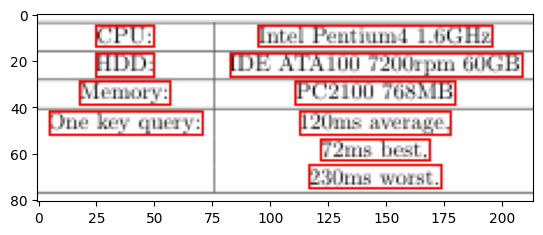

In [139]:
print(num_rows, num_columns)
draw = ImageDraw.Draw(image_table)
for cell in table_dict['cells']:
    bbox_cell = cell['pdf_text_tight_bbox']
    if len(bbox_cell) == 0:
        continue
    x1_cell , y1_cell , x2_cell , y2_cell = bbox_cell
    x1_cell_new = x1_cell - x1_new
    y1_cell_new = y1_cell - y1_new
    x2_cell_new = x2_cell - x1_new
    y2_cell_new = y2_cell - y1_new
    bbox_cell_new = [x1_cell_new, y1_cell_new, x2_cell_new, y2_cell_new]
    
    draw.rectangle(bbox_cell_new, outline="red")
plt.imshow(image_table)
plt.show()

In [108]:
len(table_dict['cells'][0]['pdf_text_tight_bbox'])

0

In [100]:
table_dict

{'reject': [],
 'fix': [],
 'cells': [{'text_content': '',
   'pdf_text_tight_bbox': [],
   'column_nums': [0],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'DP is unexpensive',
   'pdf_text_tight_bbox': [213.33099365234375,
    349.5590515136719,
    293.7092590332031,
    359.52166748046875],
   'column_nums': [1],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'DP is expensive',
   'pdf_text_tight_bbox': [331.11199951171875,
    349.5590515136719,
    400.411865234375,
    359.52166748046875],
   'column_nums': [2],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'DP is expensive',
   'pdf_text_tight_bbox': [443.3580017089844,
    349.5590515136719,
    512.6578369140625,
    359.52166748046875],
   'column_nums': [3],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': '',
   'pdf_text_tight_bbox': [],
   'column_nums': [0],
   'row_nums': [1],
   'is_column_header': False},
  {'text_content': '

In [67]:
# test_image_read = Image.open('C:/Users/PC/Desktop/git/scitsr_process/data_scitsr/split/table_image/0207028v1.3.png')
# plt.imshow(test_image_read) 
# plt.show()

In [77]:
num_rows = len(table_dict['rows'])
num_columns = len(table_dict['columns'])
print(num_rows, num_columns)
h,w,c = image_np.shape
row_dict = {key : [] for key in range(num_rows)}

for cell in table_dict['cells']:
    if len(cell['row_nums']) == 1:
        # single cell
        idx_row = cell['row_nums'][0]
        ori_bbox = cell['pdf_text_tight_bbox']
        x1 , y1 , x2 , y2 = ori_bbox
        x1_bbox = x1 - x1_table
        y1_bbox = y1 - y1_table
        x2_bbox = x2 - x1_table
        y2_bbox = y2 - y1_table
        bbox_cell_new = [x1_bbox, y1_bbox, x2_bbox, y2_bbox]
        row_dict[idx_row].append(bbox_cell_new)
row_bbox_final = []
for row_element in row_dict:
    row_element = np.array(row_dict[row_element])
    if len(row_element) == 0:
        continue    
    y1_min = np.min(row_element[:,1]) 
    y2_max = np.max(row_element[:,3])
    
    x1 = 0
    x2 = w
    row_bbox_final.append([x1, y1_min, x2, y2_max])       
row_bbox_final

11 5


[[0, 5.0, 175, 15.709381103515625],
 [0, 19.34600830078125, 175, 29.308624267578125],
 [0, 31.70001220703125, 175, 41.662628173828125],
 [0, 44.053009033203125, 175, 54.015625],
 [0, 56.407012939453125, 175, 66.36962890625],
 [0, 68.760986328125, 175, 78.72360229492188],
 [0, 81.114013671875, 175, 91.07662963867188],
 [0, 93.46798706054688, 175, 103.43060302734375],
 [0, 105.82199096679688, 175, 115.78460693359375],
 [0, 118.17498779296875, 175, 128.13760375976562],
 [0, 130.52899169921875, 175, 140.49160766601562]]

In [80]:
num_rows = len(table_dict['rows'])
num_columns = len(table_dict['columns'])
print(num_rows, num_columns)
h,w,c = image_np.shape
col_dict = {key : [] for key in range(num_columns)}
for cell in table_dict['cells']:
    if len(cell['column_nums']) == 1:
        # single cell
        idx_col = cell['column_nums'][0]
        ori_bbox = cell['pdf_text_tight_bbox']
        x1 , y1 , x2 , y2 = ori_bbox
        x1_bbox = x1 - x1_table
        y1_bbox = y1 - y1_table
        x2_bbox = x2 - x1_table
        y2_bbox = y2 - y1_table
        bbox_cell_new = [x1_bbox, y1_bbox, x2_bbox, y2_bbox]
        col_dict[idx_col].append(bbox_cell_new)
col_bbox_final = []
for col_element in col_dict:
    col_element = np.array(col_dict[col_element])
    if len(col_element) == 0:
        continue    
    x1_min = np.min(col_element[:,0]) 
    x2_max = np.max(col_element[:,2])
    
    y1 = 0
    y2 = h
    col_bbox_final.append([x1_min, y1, x2_max, y2])
col_bbox_final

11 5


[[5.0, 0, 19.943878173828125, 145],
 [31.899002075195312, 0, 46.84288024902344, 145],
 [58.79798889160156, 0, 86.47404479980469, 145],
 [98.42698669433594, 0, 128.2450408935547, 145],
 [140.2010040283203, 0, 170.01905822753906, 145]]

In [72]:
len(table_dict['cells'][0]['row_nums'])

1

In [68]:
table_dict

{'reject': [],
 'fix': [],
 'cells': [{'text_content': 'nc',
   'pdf_text_tight_bbox': [223.11399841308594,
    325.94805908203125,
    232.650634765625,
    336.6574401855469],
   'column_nums': [0],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'nf',
   'pdf_text_tight_bbox': [250.01300048828125,
    325.94805908203125,
    259.8774108886719,
    336.6574401855469],
   'column_nums': [1],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'JV',
   'pdf_text_tight_bbox': [276.9119873046875,
    325.94805908203125,
    289.5047302246094,
    335.9106750488281],
   'column_nums': [2],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'ALG 1',
   'pdf_text_tight_bbox': [316.5409851074219,
    325.94805908203125,
    346.3590393066406,
    335.9106750488281],
   'column_nums': [3],
   'row_nums': [0],
   'is_column_header': False},
  {'text_content': 'ALG 2',
   'pdf_text_tight_bbox': [358.31500244140625,
    325.9480590820312

# data split